# MaxCut using QAOA on a 5-Node Graph

In this notebook, we demonstrate QAOA solving MaxCut on a 5-node Graph

1. [Introduction](#intro)
2. [Graph Contruction](#graphmake)
3. [Pauli Term Construction](#pauli)
4. [Parameter & Circuit Construction](#paramcircuit)
5. [Qiskit Initialization & Parameter Setting](#qiskitparam)
6. [Measure Circuit Function](#measfunc)
7. [MaxCut Objective Functions](#maxcalc)
8. [Execution and Post Processing](#exec)
9. [Run the Program](#runit)

<a id = 'intro'></a>
## 1. Introduction

### Imports

In [1]:
%pip install pandas
%pip install networkx
%pip install matplotlib
%pip install numpy
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install qiskit_aer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import math
import re
import datetime
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

<a id ='graphmake'></a>

## 2. Graph Construction

This section creates a 5-node graph with edge weights = 1

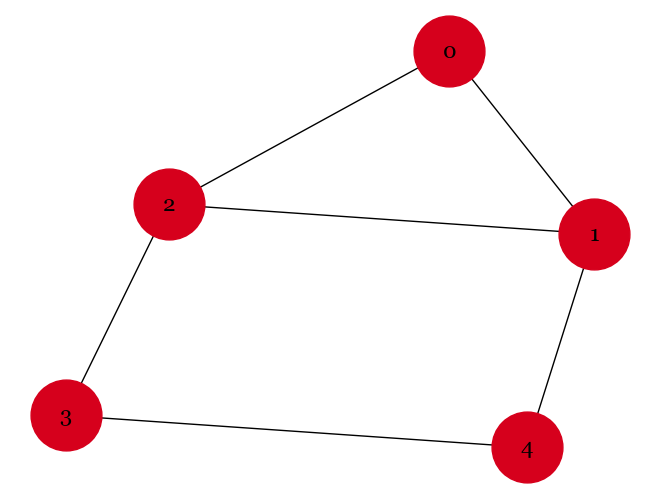

In [3]:
graph = nx.Graph()

graph.add_edge(0, 1, weight=1)
graph.add_edge(0, 2, weight=1)
graph.add_edge(1, 2, weight=1)
graph.add_edge(2, 3, weight=1)
graph.add_edge(3, 4, weight=1)
graph.add_edge(1, 4, weight=1)

reps = 4
n = graph.number_of_nodes()

pos2 = nx.spring_layout(graph)
nx.draw(graph, pos2, with_labels=True, node_color="#d6001c", node_size=2600, font_size=16, font_family="georgia")
plt.show()

<a id='pauli'></a>
## 3. Creation of Pauli terms for the Max-Cut Problem

In [4]:
def build_max_cut_paulis(graph: nx.Graph) -> list[tuple[str, float]]:
    # Convert the graph to a list of Pauli terms for the Max-Cut problem
    pauli_list = []
    num_nodes = graph.number_of_nodes()
    
    # Create a mapping of node labels to indices
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes())}

    print(node_to_index)
    
    # Iterate over the edges of the graph
    for edge in graph.edges:  
        node1, node2 = edge 
        
        # Get the corresponding indices for the nodes
        idx1, idx2 = node_to_index[node1], node_to_index[node2]
        
        paulis = ["I"] * num_nodes  # Identity on all qubits initially
        paulis[idx1], paulis[idx2] = "Z", "Z"  # Apply Z on the nodes involved in the edge
        
        # Retrieve weight using get_edge_data
        weight = graph.get_edge_data(node1, node2).get('weight', 1.0)  # Default weight is 1.0 if not provided
        
        # Add the Pauli string and its weight to the list
        pauli_list.append(("".join(paulis), weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


<a id='paramcircuit'></a>
## 3. Parameterizing and Building Quantum Circuit

In [5]:
parameterList = []

# Define parameters to be used in the circuit
for itr in range(0, reps):
    name = "gamma" + str(itr)
    parameterList.append(Parameter(name))
    name = "beta" + str(itr)
    parameterList.append(Parameter(name))

circuit = QuantumCircuit(n)

for i in range(0, n):
    circuit.h(i)

for itr in range(0, reps):
    gamma = parameterList.pop(0)
    beta = parameterList.pop(0)
    for gate in max_cut_paulis:
        i = -1
        j = -1
        k = 0
        # Apply the Rzz gates to the circuit
        for letter in gate[0]:
            if letter == "Z":
                if i == -1:
                    i = k
                else:
                    j = k
            k = k - 1

        circuit.cx(i,j)
        circuit.rz(gamma * abs(gate[1]), j)
        circuit.cx(i,j)
            
            
    for i in range(0, n):
        circuit.rx(2*beta, i)

circuit.measure_all()

<a id = 'qiskitparam'></a>
## 5. Qiskit Service Initialization and Parameter Setting

In [6]:
# Initialize Qiskit services used for processing and running of circuit
service = QiskitRuntimeService()
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
candidate_circuit = pm.run(circuit)
# initial parameter defintions to be used on unweighted graph
initial_gamma = math.pi
initial_beta = math.pi/2
init_params = []
for itr in range(0, reps):
    init_params.append(initial_beta)
    init_params.append(initial_gamma)

<a id='measfunc'></a>
## 6. Function to Measure Circuit

In [7]:
def measure_circuit(betas, gammas, n_trials=1024):
    # Get the output from circuit, either measured samples or full state vector
    backend = AerSimulator()
    qc = circuit
    for i in range(0, reps):
        qc = qc.assign_parameters({circuit.parameters[i + reps]: gammas[i]})
        qc = qc.assign_parameters({circuit.parameters[i]: betas[i]})
    qc_compiled = transpile(qc, backend)

    job_sim = backend.run(qc_compiled, shots=n_trials)

    result = job_sim.result()
    bitstrings = result.get_counts()
    return bitstrings

<a id='maxcalc'></a>

## 7. MaxCut Objective Functions

These functions are responsible for calculating the energy from each cut to evaluate the effectiveness of a cut

In [8]:
def maxcut_obj(x, G):
    # calculate energy from one bitstring
    cut = 0
    
    # Create a mapping of node labels to indices
    global node_to_index
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    
    for i, j in G.edges:
        # Get corresponding indices for nodes i and j
        idx_i, idx_j = node_to_index[i], node_to_index[j]
        
        # If the bits are different, the edge is cut
        if x[idx_i] != x[idx_j]:
            # Add the weight of the edge to the cut
            cut += G[i][j].get('weight', 1)  # Default weight is 1 if not specified
            
    return cut
def compute_maxcut_energy(counts, G):
    # compute the energy used in cut
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

def cost_func_estimator(G, p):
    def f(theta):
        # first half is betas, second half is gammas
        betas = theta[:p]
        gammas = theta[p:]   
        # define the qaoa circuit
        counts = measure_circuit(betas, gammas, n_trials=1024)
        # return the energy
        returning = -1 * compute_maxcut_energy(counts, G)
        return returning
    return f

<a id='exec'></a>
## 8. Execution and Post Processing

These functions are responsible for the running of the circuit and parsing through the results to determine an acceptable answer

In [9]:
def runit():
    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 10000

        G = graph
        obj = cost_func_estimator(G, reps)
        # using scipy.optimize built-in minimize function with COBYLA classical optimizer
        # to find the optimal parameters for this problem
        result = minimize(
            obj,
            init_params,
            method="COBYLA",
            tol=1e-2,
        )
        return result

# function to apply optimal paremeters to the circuit and find the approximated answer
def post_process(result):
    optimized_circuit = candidate_circuit.assign_parameters(result.x)
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 10000

    pub= (optimized_circuit, )
    job = sampler.run([pub], shots=int(1e4))
    counts_int = job.result()[0].data.meas.get_int_counts()
    counts_bin = job.result()[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val/shots for key, val in counts_int.items()}
    return final_distribution_int

# function to display most common bitstring to terminal
def print_most_common(final_distribution_int):
    # auxiliary functions to turn bits into a bitstring
    def to_bitstring(integer, num_bits):
        result = np.binary_repr(integer, width=num_bits)
        return [int(digit) for digit in result]

    # Find the most likely bitstring from results 
    keys = list(final_distribution_int.keys())
    values = list(final_distribution_int.values())
    most_likely = keys[np.argmax(np.abs(values))]
    most_likely_bitstring = to_bitstring(most_likely, len(graph))
    output = "".join(str(x) for x in most_likely_bitstring)
    print(output)

<a id='runit'></a>
## 9. Run the Program

In [10]:
result = runit()
final_distribution_int = post_process(result)
print_most_common(final_distribution_int)

11000
